## Assessing Service Accessibility for Asylum Seekers in Chicago

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium

from shapely.geometry import Point

pd.set_option('display.max_columns', None)

## I. Loading and Cleaning Data

In [2]:
# Location Data
shelters = pd.read_excel("../data/shelter_data.xlsx",sheet_name=0,engine="openpyxl")
public_libraries = pd.read_json("https://data.cityofchicago.org/resource/x8fc-8rcq.json")
grocery_shops = pd.read_json("https://data.cityofchicago.org/resource/ce29-twzt.json")
wifi_points = pd.read_json("https://data.cityofchicago.org/resource/4jzv-pgsc.json")
public_clinics = pd.read_json("https://data.cityofchicago.org/resource/kcki-hnch.json")
public_schools = pd.read_json("https://data.cityofchicago.org/resource/tz49-n8ze.json")
bus_stations = gpd.read_file("../data/cta_bus_stops/bus_stops_location.shp")
rail_stations = gpd.read_file("../data/cta_rail_stations/CTA_RailStations.shp")

# Boundary Data
neigh_bound = gpd.read_file("../data/neighborhood_boundaries/neigh_bound.shp")
parks_bound = gpd.read_file("../data/parks_boundaries/parks_bound.shp")

### I.a Geocode Datasets

The data sources don’t have a homogeneous format, so we need to ensure that the locations of shelters, grocery shops, Wi-Fi points, public schools, clinics, bus stops, and rail stops are properly geocoded.

Given that the files already have variables in degrees, even though not properly geocoded, we define their geometries using the EPSG:4326 - [World Geodetic System (WGS84)](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84), a latitude/longitude Coordinate Reference System (CRS) based on the Earth's center of mass. In later sections, we'll transform the CRS to accurate distance measurement. For this, we'll use the EPSG:3857 - [Web Mercator projection](https://en.wikipedia.org/wiki/Web_Mercator_projection) to calculate buffers and distances.

In [4]:
# Define function that geocode datasets
def geocode_df(df, only_change_crs):
    """
    This function takes a pandas df and converts it to a GeoDataFrame by creating
    a geometry variable and assigning a the EPSG:4326 Coordinate Reference System.

    Input:
        df: a pandas DataFrame
        only_change_crs (bool): True if the dataset is already geocoded and only
            requires to specify the CRS.
    
    Output:
        gdf: a GeoDataFrame
    """
    if only_change_crs:
        gdf = df.to_crs(epsg=4326)
    else:
        cond_1 = ("latitude" and "longitude") in df.columns
        cond_2 = ("y" and "x") in df.columns
        if cond_1 or cond_2:
            if cond_2:
                df.rename(columns={"y": "latitude", "x": "longitude"}, inplace=True)
        else:
            df["latitude"] = df["location"].apply(lambda row: row["latitude"])
            df["longitude"] = df["location"].apply(lambda row: row["longitude"])
        
        df["geometry"] = [Point(lon, lat) for lon, lat in zip(df["longitude"], df["latitude"])]
        gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=df["geometry"])

    return gdf

In [5]:
dfs_geocode = [("shelters", False), ("public_libraries", False),
               ("grocery_shops", False), ("wifi_points", False),
               ("public_clinics", False), ("public_schools", False),
               ("bus_stations", True), ("rail_stations", True),
               ("parks_bound", True), ("neigh_bound", True)]

for dfs in dfs_geocode:
    df_name, operation = dfs
    input_df = globals()[df_name]  # Get the DataFrame by name
    geo_df = geocode_df(input_df, operation)
    globals()["geo_" + df_name] = geo_df  # Assign the result to a new global variable
    print("Created geo_",df_name," using ", df_name,sep="")
    print("  The CRS of the data is now",geo_df.crs)

Created geo_shelters using shelters
  The CRS of the data is now EPSG:4326
Created geo_public_libraries using public_libraries
  The CRS of the data is now EPSG:4326
Created geo_grocery_shops using grocery_shops
  The CRS of the data is now EPSG:4326
Created geo_wifi_points using wifi_points
  The CRS of the data is now EPSG:4326
Created geo_public_clinics using public_clinics
  The CRS of the data is now EPSG:4326
Created geo_public_schools using public_schools
  The CRS of the data is now EPSG:4326
Created geo_bus_stations using bus_stations
  The CRS of the data is now EPSG:4326
Created geo_rail_stations using rail_stations
  The CRS of the data is now EPSG:4326
Created geo_parks_bound using parks_bound
  The CRS of the data is now EPSG:4326
Created geo_neigh_bound using neigh_bound
  The CRS of the data is now EPSG:4326


### I.b Subsetting the Data

In [11]:
# Remove useless columns from each dataset
geo_public_libraries = geo_public_libraries[['name_','latitude','longitude','geometry']]
geo_grocery_shops = geo_grocery_shops[['community_area_name','latitude','longitude','geometry']]
geo_wifi_points = geo_wifi_points[['organization_name','latitude','longitude','geometry']]
geo_public_clinics = geo_public_clinics[['site_name','latitude','longitude','geometry']]
geo_public_schools = geo_public_schools[['school_nm','latitude','longitude','geometry']]
geo_bus_stations = geo_bus_stations[['public_nam','geometry']]
geo_rail_stations = geo_rail_stations[['LONGNAME','geometry']]
geo_parks_bound = geo_parks_bound[['park','geometry']]
geo_neigh_bound = geo_neigh_bound[['pri_neigh','sec_neigh','geometry']]

## II. Defining Buffer Distances

We need to define what distance is considered accessible for each type of service. After this, we’ll create buffer zones around each shelter. The size of these buffers will be based on distances defined as accessible. The selection criteria is the following:

* **Public libraries**: Following a study from [Donelly (2015)](https://www.sciencedirect.com/science/article/abs/pii/S0740818815000869) and this post about [average distance to libraries in the US](https://atcoordinates.info/2016/02/22/average-distance-to-public-libraries-in-the-us/), we use a two-mile buffer to define accessibility to library services.

* **Grocery shops**: Based on research from the [Department of Agriculture](https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation/), and [Wilde et. al (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5998793/) a grocery store is considerable accesible in an urban area if it's within a 1 mile radius from a person's location.

* **Wi-Fi points**: Given the lack of studies on accesibility to internet services, we define a buffer zone of 1 mile to Wi-Fi points.

* **Public clinics**: Based on a paper from [Luo and Wang (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8238135/) on Spatial Accessibility to Healthcare in Chicago, we define a buffer zone of 15 miles for public hospitals.

* **Public schools**: Using a study from the [US Department of Transportation](https://nhts.ornl.gov/briefs/travel%20to%20school.pdf) and from the [Kinder Institute for Urban Research](https://kinder.rice.edu/research/staying-neighborhood-examining-distance-zoned-schools-and-access-transportation#:~:text=The%20average%20distance%20between%20an,to%20enroll%20in%20that%20school.), we define a school as accesible if it's within a 2 mile radius from a family household in urban areas.

* **Transportation points**: Based on research from the [US Department of Transportation](https://safety.fhwa.dot.gov/ped_bike/ped_transit/ped_transguide/ch4.cfm), most people are willing to walk for five to ten minutes, or approximately a quarter of half mile to a transit stop. Given that Chicago is one of the major cities in the US, we define a 1/2 mile radius as accessible distance.

* **Green spaces**: [Nesbitt et. al (2018)](https://www.sciencedirect.com/science/article/pii/S0169204618307710) conducted a spatial analysis of distributional green equity in 10 US cities. In their study, they mentioned that urban residents in the US walk 1.3 mi, or just over 2 km, on average, during recreational walking trips, suggesting that 1000 m is an average distance that most urban residents would walk to a park. Given this, we define a park as accesible if it is in a 0.63 miles radius. 

The representation of the buffers for each service is stored in a dictionary:

In [12]:
serv_buffer = {
    "public_libraries": 2,
    "grocery_shops": 1,
    "wifi_points": 1,
    "public_clinics": 15,
    "public_schools": 2,
    "bus_stations": 0.5,
    "rail_stations": 0.5,
    "parks_bound": 0.63,
}

## III. Calculating Accesibility Indices

### III.a Count of Services

To create an accesibility index, we first calculate a buffer for a specific service. Once the buffer is created, we count the number of services that fall within that buffer. The index is created following the normalization approach described in the `README.md` of the repo. Intuitevily, the higher the index, the greater the access to a specific service or set of services.

We'll calculate the buffers for both shelters and neighborhood centroids. The reason for this is that we'll use the data from the neighborhoods as a *proxy* measure to understand how many services a household located in a neighborhood would have. In this sense, the indices that we calculate for shelters will be compared to the data from neigjborhoods as it serves as a benchmark. The function `count_services` handles the buffer creation and service counts:

In [22]:
def count_services(df_name, buffer_keys):
    """
    This function calculates buffers in meters around each geometry in `df` based
    on specified distances, and counts the number of services falling within each buffer.
    The results are returned in a new GeoDataFrame.

    Inputs:
        df: GeoDataFrame with geometries in a projected CRS
        buffer_keys: dict with names of services and buffer distances in miles

    Output:
        new_df: GeoDataFrame with additional columns with the counts for each service
            that falls within a specific buffer
    """
    new_df = globals()[df_name]
    services = list(buffer_keys.keys())
    for service in services:
        # Load the service GeoDataFrame
        df_comparison = globals()["geo_" + service]

        # Change geometry to calculate distances
        new_df.to_crs(epsg=3857, inplace=True)
        df_comparison.to_crs(epsg=3857, inplace=True)

        # Calculate buffers in meters
        buffer_distance_m = buffer_keys[service] * 1609.34
        if df_name == "geo_neigh_bound":
            new_df.loc[:,'geometry'] = new_df.loc[:,'geometry'].centroid
        buffers = new_df['geometry'].buffer(buffer_distance_m)
        
        # Initialize a column for the service counts
        new_df[service] = 0
        for idx, buffer in enumerate(buffers):
            # Count how many service points intersect with the buffer
            cnt_services = df_comparison['geometry'].intersects(buffer).sum()
            new_df.loc[idx, service] = cnt_services
        
    # Change CRS to original
    new_df.to_crs(epsg=4326, inplace=True)

    return new_df

In [27]:
cnt_servs_neigh = count_services("geo_neigh_bound",serv_buffer)
cnt_servs_shelters = count_services("geo_shelters",serv_buffer)

In [ ]:
cnt_servs_neigh.columns

Index(['pri_neigh', 'sec_neigh', 'geometry', 'public_libraries',
       'grocery_shops', 'wifi_points', 'public_clinics', 'public_schools',
       'bus_stations', 'rail_stations', 'parks_bound'],
      dtype='object')

### III.b Normalization

We will use the neighborhood results as the benchmark to compare the values obtained for the shelters. We begin by normalizing the results, and creating an aggregated index by service. This aggregation is done by taking the average of the normalized value for each neighborhood. This process is done in the `normalize_counts` function: 

In [48]:
def normalize_counts(df_to_normalize, df_distribution, vars_normalize):
    """
    This function normalizes the values obtained from the counts of services to
    make them comparable.

    Input:
        df_to_normalize: a DataFrame whose values will be normalized
        df_distribution: a DataFrame whose distrution will be used for the
            normalization operation.

    Output:
        norm_df: a DataFrame with normalized values
    """

    norm_df = df_to_normalize.copy()
    id_cols = [col for col in norm_df.columns if col not in vars_normalize]
    
    for var in vars_normalize:
        # Calculate the mean and standard deviation from the initial dataset
        mean = df_distribution[var].mean()
        sd = df_distribution[var].std()

        # Normalize the appropiate dataset using the mean and standard deviation from the initial dataset
        norm_df[var + '_norm'] = (norm_df[var] - mean) / sd

        # Apply a logistic transformation to the normalized values of the new dataset
        def logistic_transform(x):
            return 1 / (1 + np.exp(-x))
        
        norm_df[var + '_index'] = norm_df[var + '_norm'].apply(logistic_transform) * 100
    
    # Keep index variables only
    cols_keep = [col for col in norm_df.columns if '_index' in col]
    id_cols =+ cols_keep
    norm_df = norm_df[id_cols]

    return norm_df

In [47]:
normalize_counts(cnt_servs_neigh,cnt_servs_neigh,serv_buffer.keys())

,pri_neigh,sec_neigh,geometry,public_libraries_index,grocery_shops_index,wifi_points_index,public_clinics_index,public_schools_index,bus_stations_index,rail_stations_index,parks_bound_index
0,Grand Boulevard,BRONZEVILLE,POINT (-87.61786 41.81295),79.461761,49.726666,66.516770,68.730459,74.293212,67.105309,75.686750,86.280724
1,Printers Row,PRINTERS ROW,POINT (-87.62903 41.87098),38.022842,43.074720,76.135606,73.239510,35.208749,84.898731,93.591020,79.710550
2,United Center,UNITED CENTER,POINT (-87.67914 41.88197),79.461761,25.304972,83.669604,68.730459,91.964237,65.361617,39.889506,48.919930
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,POINT (-87.65367 41.92719),60.639992,56.388303,32.415367,68.730459,49.498474,36.941811,58.970724,71.049666
4,Humboldt Park,HUMBOLDT PARK,POINT (-87.71651 41.90089),60.639992,74.279482,83.669604,68.730459,83.903680,59.893641,39.889506,71.049666
...,...,...,...,...,...,...,...,...,...,...,...
93,Belmont Cragin,"BELMONT CRAGIN,HERMOSA",POINT (-87.76550 41.92726),60.639992,91.681927,43.511080,42.341876,59.221938,61.751515,39.889506,27.205595
94,Austin,AUSTIN,POINT (-87.75801 41.89065),60.639992,30.692329,66.516770,68.730459,61.572694,38.776070,58.970724,71.049666
95,Gold Coast,GOLD COAST,POINT (-87.62710 41.90601),38.022842,68.840561,43.511080,68.730459,30.864093,85.871519,58.970724,60.522731
96,Boystown,BOYSTOWN,POINT (-87.64745 41.94392),79.461761,43.074720,55.297301,42.341876,35.208749,90.657664,39.889506,60.522731


<Axes: >

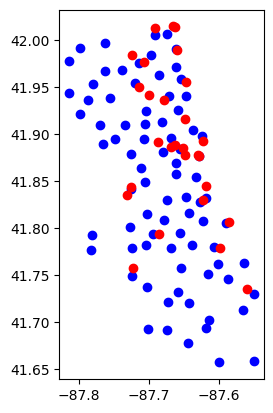

In [33]:
# base = geo_public_libraries.geometry.plot(color='blue')
# geo_shelters.geometry.plot(ax=base, color='red')

## III. Calculating Accesibility Indices

### III.a Individual Indices

For each shelter, we calculate how many of each type of service (grocery shops, wifi points, etc.) fall within its buffer zone using spatial operations. This will give us a raw count of accessible services. To make these counts comparable across shelters, we’ll normalize them in a uniform range (*i.e.*, 0 to 100). For sake of simplicity, we’ll treat every service as equally important so there is no need to define specific weights.

### III.b Aggregated Index

After calculating the normalized individual indices, we’ll combine them into a final index for each shelter. This can be a simple average if all services are considered equally important.

## IV. Visualization

Finally, we’ll use the final aggregated index to rank shelters in terms of their access to essential services. We’ll then create a geospatial visualization to represent the accessibility of each shelter visually.